In [1]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")
from chiseling.dgps.heterogeneous_linear_rct import HeterogeneousLinearRCT

### I/O

In [2]:
FIGURE_SAVEPATH = "../../../figures/"
TYPE1_ERROR_SAVEPATH = "../../../output/type1_errors/"
SAVELABEL = "heterogeneous_linear_rct_extrap"

SAVE = False

### Formatting

In [3]:
method_cmap = {("Chiseling", 0): "#FF590D",
               ("Chiseling", 1): "#2032DA",
               "DataSplittingStrategy": "#FFBB00",
               "SimulDataSplittingStrategy": "#69C1B9",
               "OracleStrategy": "#000000",
               "OracleSimulStrategy": "#919191",
               "TTestStrategy": "#E70202"}
method_pretty_name_map = {("Chiseling", 0): "NONAME",
                          ("Chiseling", 1): "Chiseling",
                          "DataSplittingStrategy": "Data Splitting",
                          "SimulDataSplittingStrategy": "Simul. Data Splitting",
                          "OracleStrategy": "Oracle",
                          "OracleSimulStrategy": "Simul. Oracle",
                          "TTestStrategy": r"$t$-test"}
comp_method_pretty_name_map = {("Chiseling", 0): "Chiseling (Single)",
                               ("Chiseling", 1): "Chiseling (Multiple)"}

MARKERSIZE = 150
LABEL_FONTSIZE = 28
TITLE_FONTSIZE = 32
LEGEND_FONTSIZE = 25
TICK_FONTSIZE = 24
HIDESPINES = True
LINEWIDTH = 4

SIZE_NAME = r"$P(X \in \mathcal{R}^{*})$"

### Preprocessing

In [4]:
task_array_path = "../../task_arrays/heterogeneous_linear_rct_extrap.tasks.tsv"
res_path = "../../../output/heterogeneous_linear_rct_extrap/heterogeneous_linear_rct_extrap.combined.tsv"

In [5]:
task_df = pd.read_csv(task_array_path, sep="\t", index_col=None)
res_df = pd.read_csv(res_path, sep="\t", index_col=None)
# Merge task meta and results
res_df = res_df.merge(task_df, how="left", on="task_id")

In [6]:
# Aggregate results
setting_identifiers = ["n", "theta", "tau", "subgroup_size", "strategy", "margin_width",
                       "n_burn_in", "train_ratio", "bonf_strategy"]
agg_res_df = res_df.groupby(setting_identifiers, dropna=False)[["rejected", "subgroup_utility", "region_mass"]].agg(["mean", "var", "count"])
agg_res_df.columns = ["_".join(c) for c in agg_res_df.columns.to_flat_index()]
agg_res_df = agg_res_df.reset_index()
agg_res_df["rejected_se"] = np.sqrt(agg_res_df.rejected_var / agg_res_df.rejected_count)
agg_res_df["subgroup_utility_se"] = np.sqrt(agg_res_df.subgroup_utility_var / agg_res_df.subgroup_utility_count)
agg_res_df["region_mass_se"] = np.sqrt(agg_res_df.region_mass_var / agg_res_df.region_mass_count)
agg_res_df = agg_res_df.loc[:,setting_identifiers + ["rejected_mean", "rejected_se",
                                                     "subgroup_utility_mean", "subgroup_utility_se",
                                                     "region_mass_mean", "region_mass_se"]]

### Settings

In [7]:
# size, n, theta, tau
dgp_settings = [(0.5, 1000, 0.5, 0),
                (0.1, 5000, 0.5, -0.769),
                (0.01, 25000, 0.8, -2.248)]
viz_dgp_settings = [(0.5, 1000, 0.5, 0),
                    (0.1, 5000, 0.5, -0.769),
                    (0.01, 25000, 0.8, -2.248)]
margin_width_settings = [0, 1]
viz_margin_width_settings = [1]

### Standardize by optimal region utilities

In [8]:
# Hyperparameters
d = 100
s = 10
rho = 0.2

test_thresh = 0
random_seed = 42

In [9]:
# utility, size, mean, and standard errors
opt_region_metrics_dict = {}
for (subgroup_size, n, theta, tau) in dgp_settings:
    sampler = HeterogeneousLinearRCT(d, s, rho, theta, tau, random_seed=random_seed)
    opt_region_metrics = sampler.get_optimal_region_metrics()
    opt_region_metrics_dict[(theta, tau)] = opt_region_metrics

In [10]:
# Calculate normalized utilities
agg_res_df["opt_utility"] = agg_res_df.apply(lambda row:
                                             opt_region_metrics_dict[(row.theta, row.tau)][0],
                                             axis=1)
agg_res_df["norm_subgroup_utility_mean"] = (agg_res_df["subgroup_utility_mean"] /
                                            agg_res_df["opt_utility"])

### Visualizations

Expected utility

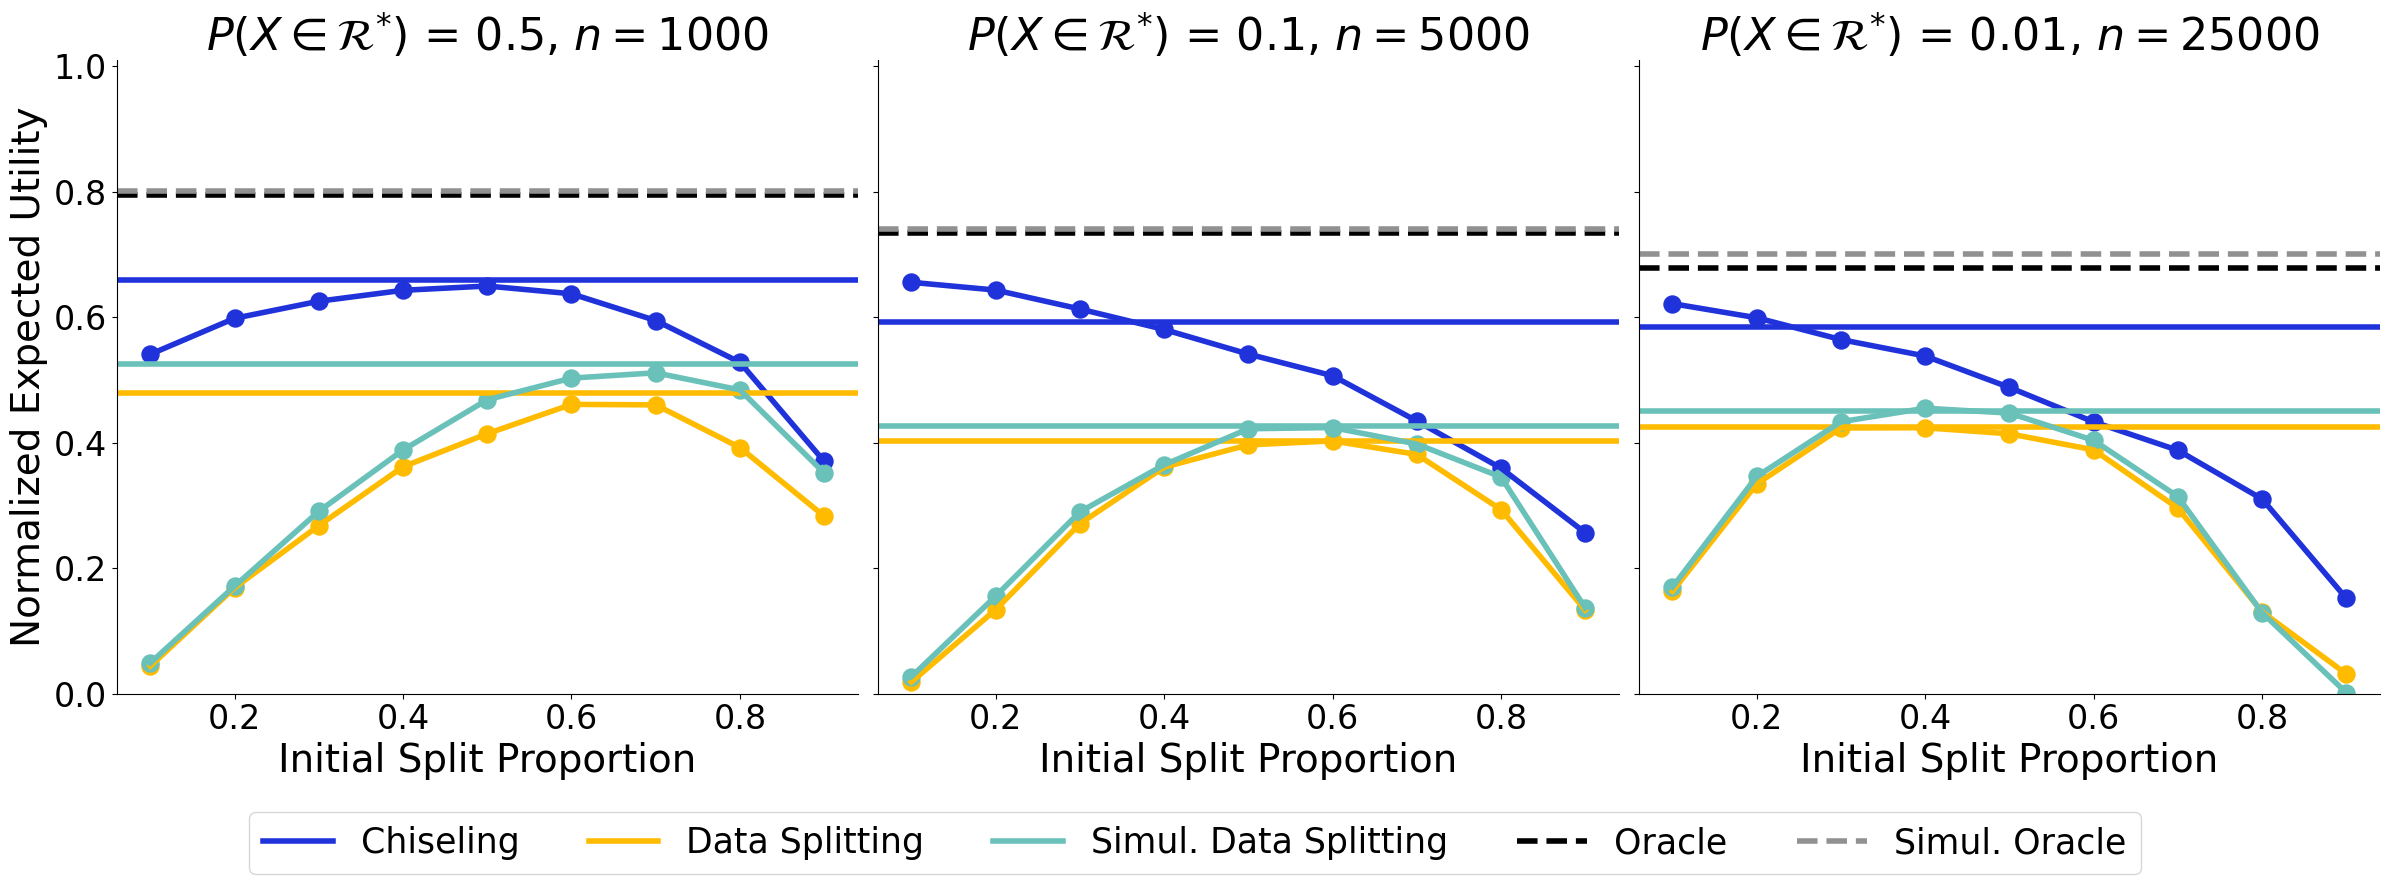

In [11]:
fig, ax = plt.subplots(1,3,figsize=(24,8), sharey=True)

VIZ_PROPERTY = "norm_subgroup_utility_mean"
YLABEL = "Normalized Expected Utility"
PLOT_SAVELABEL = "utility"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for (subgroup_size, n, theta, tau) in viz_dgp_settings:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.subgroup_size == subgroup_size]
    sub_res_df = sub_res_df[sub_res_df.n == n]
    sub_res_df = sub_res_df[sub_res_df.theta == theta]
    sub_res_df = sub_res_df[sub_res_df.tau == tau]
    # Chiseling methods
    for margin_width in viz_margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                        color=color, linewidth=LINEWIDTH)
    # Data splitting
    color = method_cmap["DataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["DataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    color=color, linewidth=LINEWIDTH)
    # Simultaneous data splitting
    color = method_cmap["SimulDataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title("{} = {}, $n = {}$".format(SIZE_NAME, subgroup_size, n), fontsize=TITLE_FONTSIZE)
    # Set ylim
    ax[AX0].set_ylim(0,1+0.01)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
# ax[-1].legend(fontsize=LEGEND_FONTSIZE)
handles, _ = ax[1].get_legend_handles_labels()
fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
           bbox_to_anchor=(0.5, 0), fancybox=True, ncols=5)
plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

Power

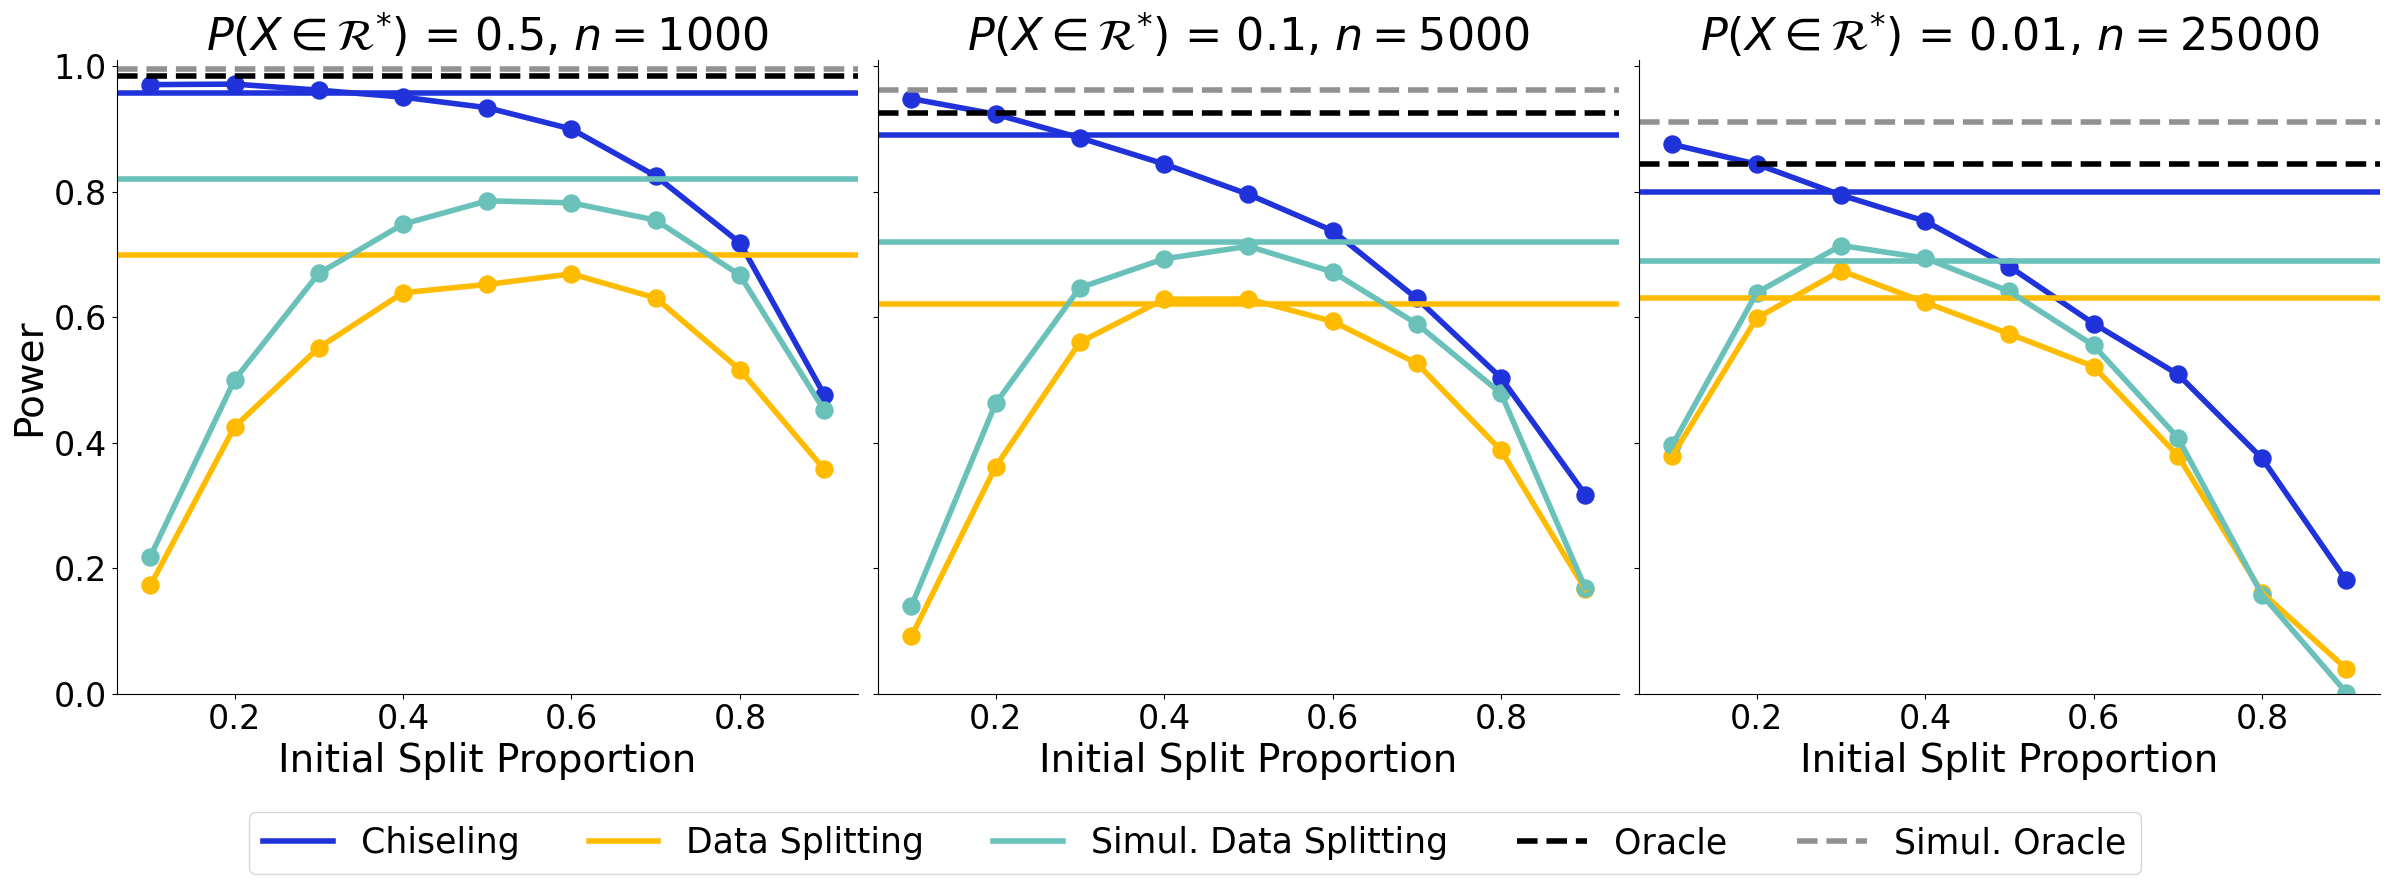

In [12]:
fig, ax = plt.subplots(1,3,figsize=(24,8), sharey=True)

VIZ_PROPERTY = "rejected_mean"
YLABEL = "Power"
PLOT_SAVELABEL = "power"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for (subgroup_size, n, theta, tau) in viz_dgp_settings:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.subgroup_size == subgroup_size]
    sub_res_df = sub_res_df[sub_res_df.n == n]
    sub_res_df = sub_res_df[sub_res_df.theta == theta]
    sub_res_df = sub_res_df[sub_res_df.tau == tau]
    # Chiseling methods
    for margin_width in viz_margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                        color=color, linewidth=LINEWIDTH)
    # Data splitting
    color = method_cmap["DataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["DataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "DataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "DataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    color=color, linewidth=LINEWIDTH)
    # Simultaneous data splitting
    color = method_cmap["SimulDataSplittingStrategy"]
    method_pretty_name = method_pretty_name_map["SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "SimulDataSplittingStrategy"]
    sub_sub_res_df = sub_sub_res_df.sort_values("train_ratio")
    ax[AX0].plot(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                 label=method_pretty_name, color=color, linewidth=LINEWIDTH)
    ax[AX0].scatter(sub_sub_res_df.train_ratio, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                    color=color, s=MARKERSIZE)
    # Bonferroni combination for simultaneous data splitting
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "SimulDataSplittingStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0], color=color, linewidth=LINEWIDTH)
    # Oracle
    color = method_cmap["OracleStrategy"]
    method_pretty_name = method_pretty_name_map["OracleStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Oracle simultaneous
    color = method_cmap["OracleSimulStrategy"]
    method_pretty_name = method_pretty_name_map["OracleSimulStrategy"]
    sub_sub_res_df = sub_res_df
    sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "OracleSimulStrategy"]
    ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                    label=method_pretty_name, linestyle="--", color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title("{} = {}, $n = {}$".format(SIZE_NAME, subgroup_size, n), fontsize=TITLE_FONTSIZE)
    # Set ylim
    ax[AX0].set_ylim(0,1+0.01)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
# ax[-1].legend(fontsize=LEGEND_FONTSIZE)
handles, _ = ax[1].get_legend_handles_labels()
fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
           bbox_to_anchor=(0.5, 0), fancybox=True, ncols=5)
plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

Multiple vs. single chiseling utility

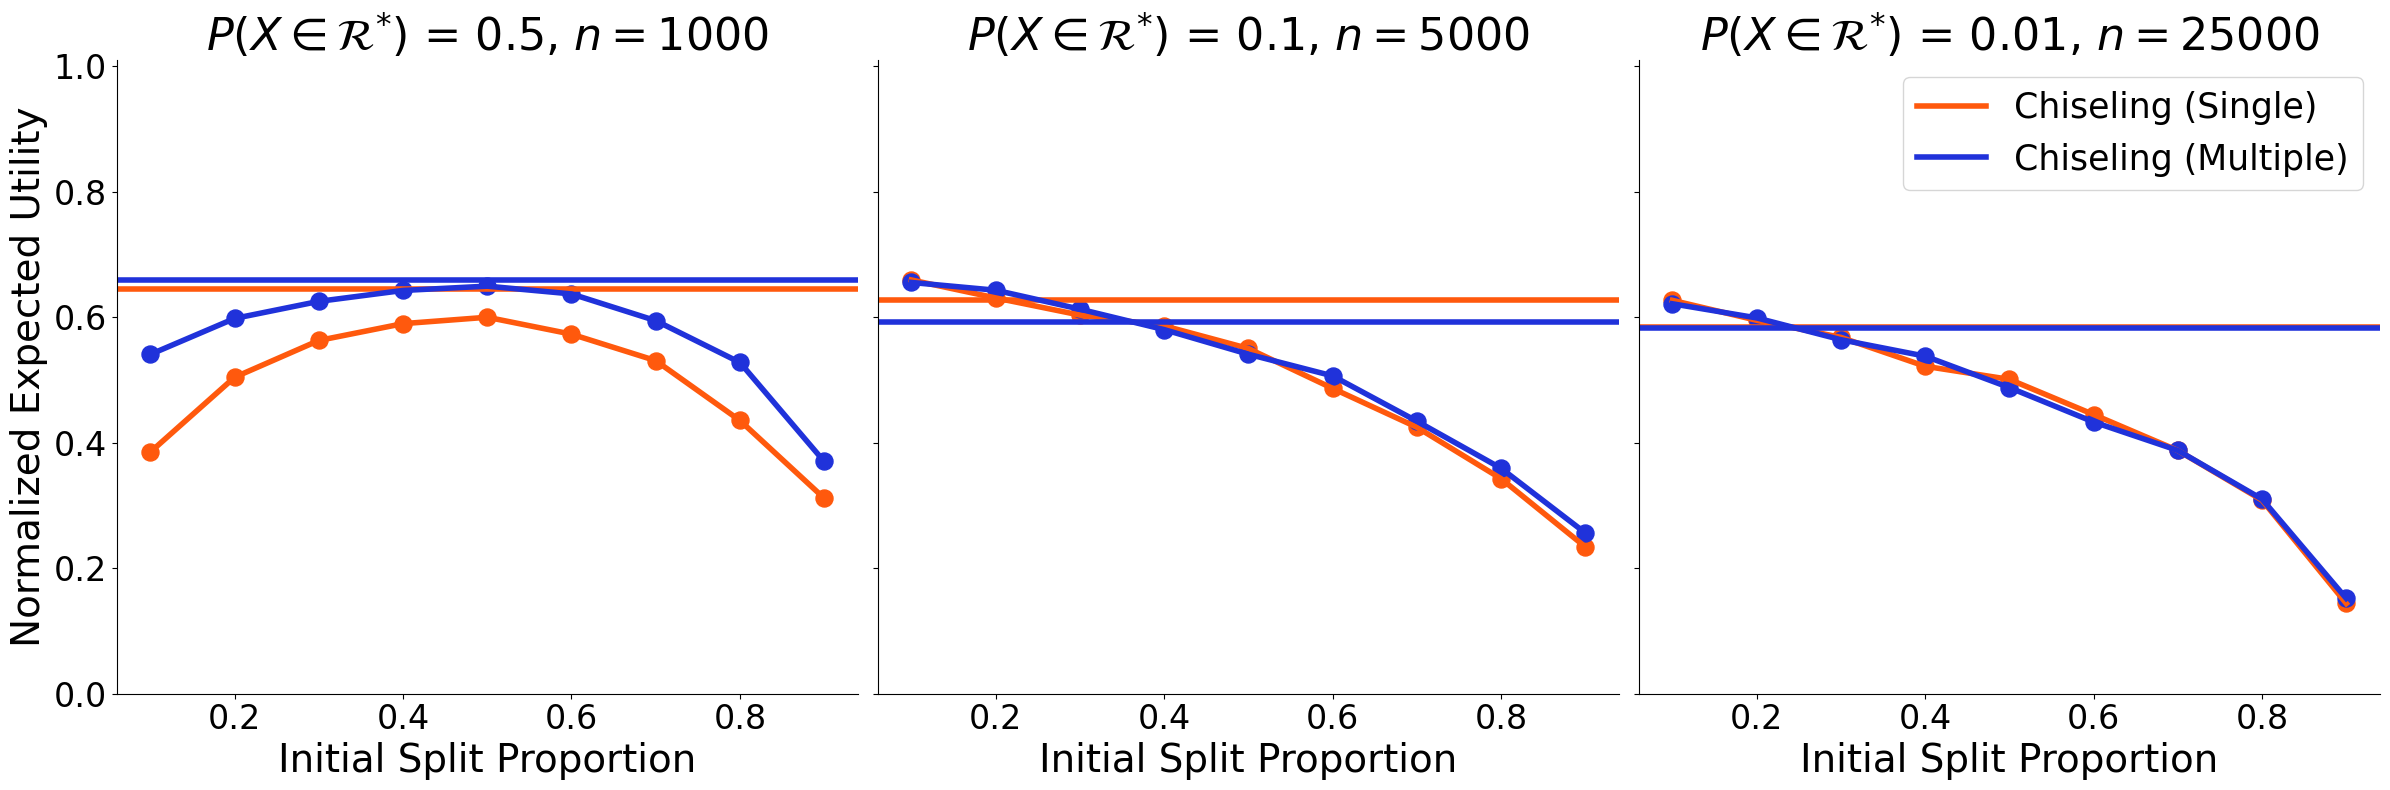

In [13]:
fig, ax = plt.subplots(1,3,figsize=(24,8), sharey=True)

VIZ_PROPERTY = "norm_subgroup_utility_mean"
YLABEL = "Normalized Expected Utility"
PLOT_SAVELABEL = "multi_v_single.utility"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for (subgroup_size, n, theta, tau) in viz_dgp_settings:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.subgroup_size == subgroup_size]
    sub_res_df = sub_res_df[sub_res_df.n == n]
    sub_res_df = sub_res_df[sub_res_df.theta == theta]
    sub_res_df = sub_res_df[sub_res_df.tau == tau]
    # Chiseling methods
    for margin_width in margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = comp_method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                        color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title("{} = {}, $n = {}$".format(SIZE_NAME, subgroup_size, n), fontsize=TITLE_FONTSIZE)
    # Set ylim
    ax[AX0].set_ylim(0,1+0.01)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
ax[-1].legend(fontsize=LEGEND_FONTSIZE)
# handles, _ = ax[1].get_legend_handles_labels()
# fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
#            bbox_to_anchor=(0.5, 0), fancybox=True, ncols=5)
plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

Multiple vs. single chiseling power

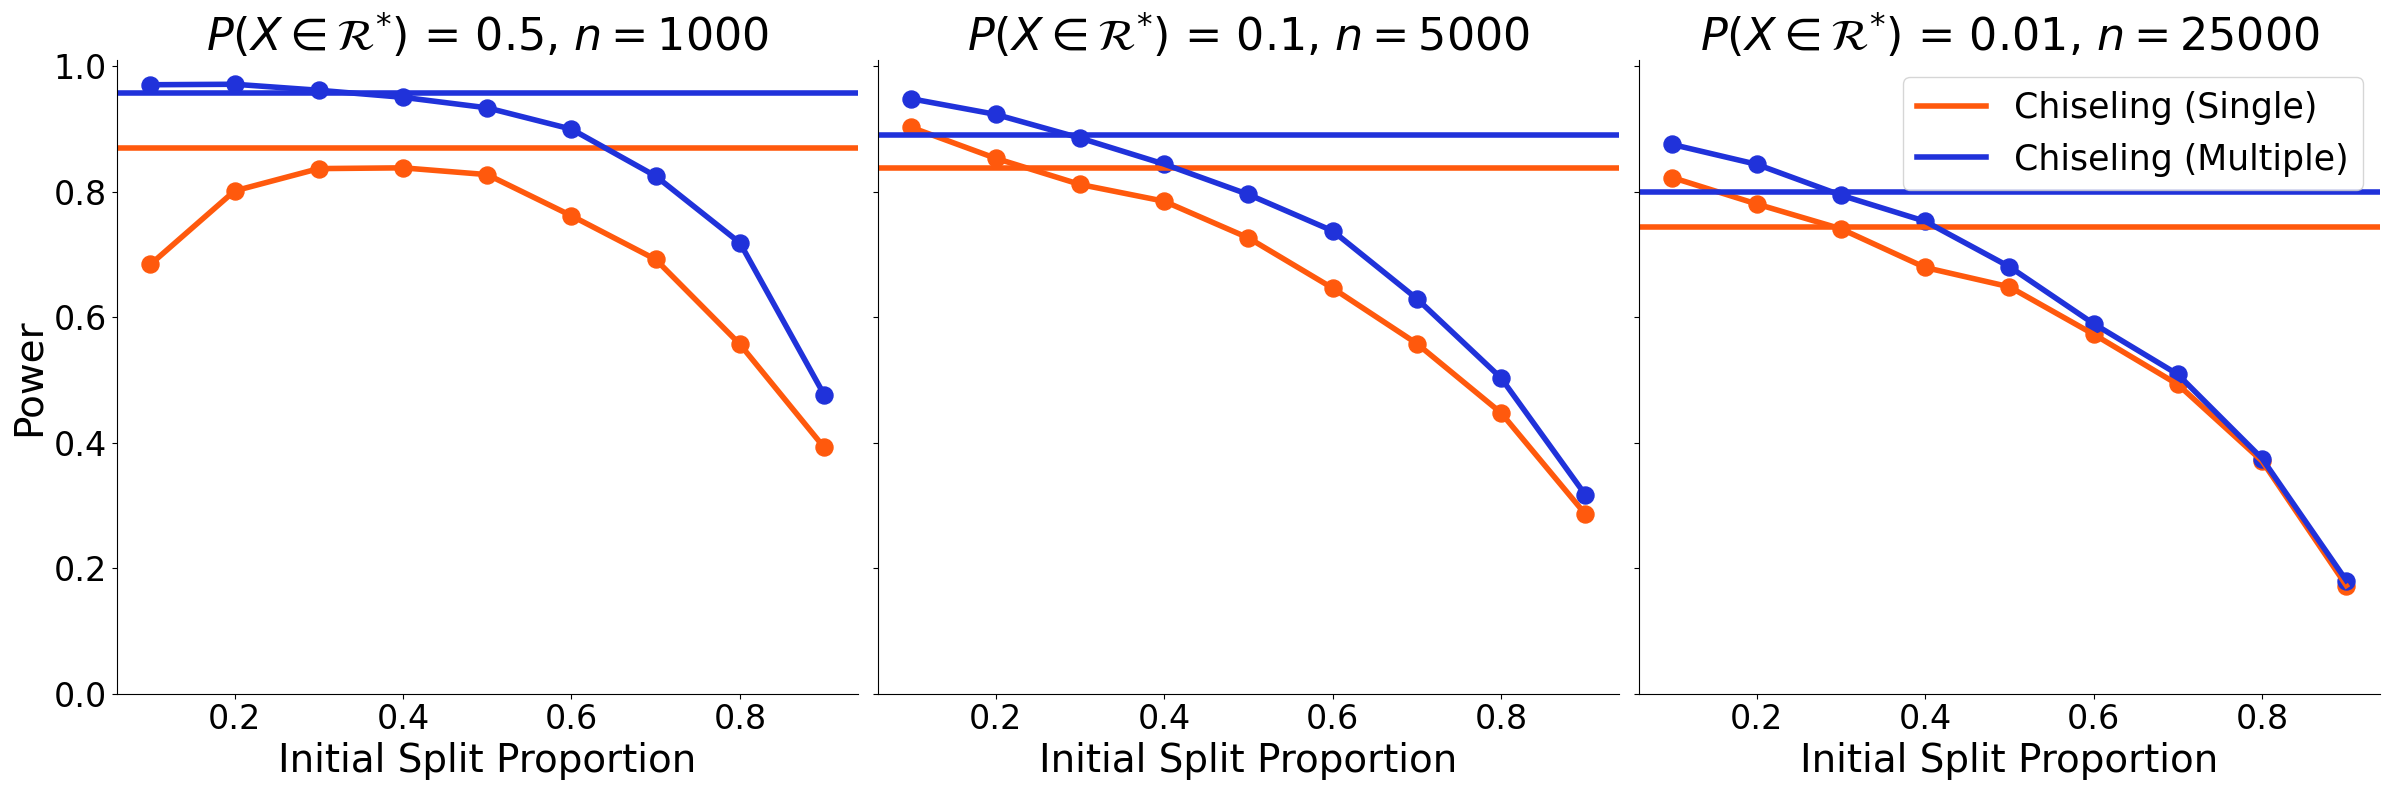

In [14]:
fig, ax = plt.subplots(1,3,figsize=(24,8), sharey=True)

VIZ_PROPERTY = "rejected_mean"
YLABEL = "Power"
PLOT_SAVELABEL = "multi_v_single.power"

# Initialize panel coordinates
PANEL_COUNTER = 0
AX0 = PANEL_COUNTER

for (subgroup_size, n, theta, tau) in viz_dgp_settings:
    sub_res_df = agg_res_df
    sub_res_df = sub_res_df[sub_res_df.subgroup_size == subgroup_size]
    sub_res_df = sub_res_df[sub_res_df.n == n]
    sub_res_df = sub_res_df[sub_res_df.theta == theta]
    sub_res_df = sub_res_df[sub_res_df.tau == tau]
    # Chiseling methods
    for margin_width in margin_width_settings:
        color = method_cmap[("Chiseling", margin_width)]
        method_pretty_name = comp_method_pretty_name_map[("Chiseling", margin_width)]
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        sub_sub_res_df = sub_sub_res_df.sort_values("n_burn_in")
        ax[AX0].plot(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                     label=method_pretty_name, color=color, linewidth=LINEWIDTH)
        ax[AX0].scatter(sub_sub_res_df.n_burn_in, sub_sub_res_df.loc[:,VIZ_PROPERTY],
                        color=color, s=MARKERSIZE)
        # Bonferroni combination for chiseling
        sub_sub_res_df = sub_res_df
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.strategy == "BonferroniCombiner"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.bonf_strategy == "Chiseling"]
        sub_sub_res_df = sub_sub_res_df[sub_sub_res_df.margin_width == margin_width]
        ax[AX0].axhline(sub_sub_res_df.loc[:,VIZ_PROPERTY].values[0],
                        color=color, linewidth=LINEWIDTH)
    # Add title
    ax[AX0].set_title("{} = {}, $n = {}$".format(SIZE_NAME, subgroup_size, n), fontsize=TITLE_FONTSIZE)
    # Set ylim
    ax[AX0].set_ylim(0,1+0.01)
    # Set x-labels
    ax[AX0].set_xlabel("Initial Split Proportion", fontsize=LABEL_FONTSIZE)
    # Tick fontsize
    ax[AX0].tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    if HIDESPINES:
        ax[AX0].spines[['right', 'top']].set_visible(False)
    # Increment panel coordinates
    PANEL_COUNTER += 1
    AX0 = PANEL_COUNTER

# Global formatting
ax[0].set_ylabel(YLABEL, fontsize=LABEL_FONTSIZE)
ax[-1].legend(fontsize=LEGEND_FONTSIZE)
# handles, _ = ax[1].get_legend_handles_labels()
# fig.legend(handles=handles, fontsize=LEGEND_FONTSIZE, loc='upper center',
#            bbox_to_anchor=(0.5, 0), fancybox=True, ncols=5)
plt.tight_layout()

# Save
if SAVE:
    plt.savefig(FIGURE_SAVEPATH + "{}.{}.pdf".format(SAVELABEL, PLOT_SAVELABEL), bbox_inches="tight", dpi=300)

plt.show()

### Type I error

In [15]:
# Add error column
res_df["error"] = res_df.rejected & (res_df.subgroup_utility <= 0)

In [16]:
# Aggregate
error_df = res_df.groupby(setting_identifiers, dropna=False)[["error"]].agg(["mean", "var", "count"])
error_df.columns = ["_".join(c) for c in error_df.columns.to_flat_index()]
error_df = error_df.reset_index()
error_df["error_se"] = np.sqrt(error_df.error_var / error_df.error_count)

error_df = error_df.loc[:,setting_identifiers + ["error_mean", "error_se"]]

In [17]:
# Subset to only chiseling methods
error_df = error_df[(error_df.strategy == "Chiseling") | (error_df.bonf_strategy == "Chiseling")]

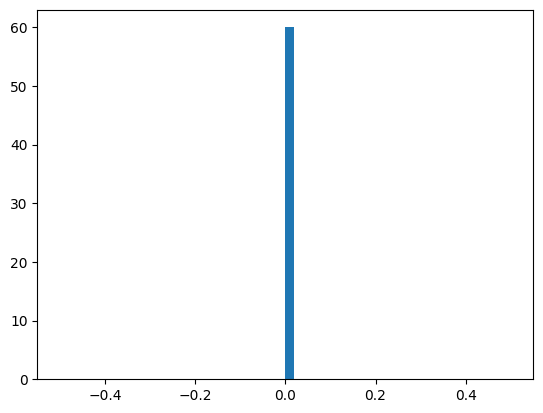

Min = 0.0 / Max = 0.0


In [18]:
# Visualize here as a sanity check
plt.hist(error_df.error_mean.values, bins=50)
plt.show()

print("Min = {} / Max = {}".format(error_df.error_mean.min(), error_df.error_mean.max()))

In [19]:
# Save
if SAVE:
    error_df.to_csv(TYPE1_ERROR_SAVEPATH + "{}.{}.tsv".format(SAVELABEL, "t1e"), sep="\t", index=False)